# NSRDB

<details>
  <summary>
    NSRDB Summary
  </summary>
    - record 04015 ([1:8])
    <br>- record 04043 ([1:16])
    <br>- record 04048 ([1:6])
    <br>- record 04126 ([1:])
    <br>- record 04746 (tidak di proses, karena kebanyakan data N)
    <br>- record 04908 ([1:]) -> annotate.txt nya di custom
    <br>- record 04936 ([4:])
    <br>- record 05091 ([1:])
    <br>- record 05121 ([1:])
    <br>- record 05261 ([1:18])
    <br>- record 06426 ([1:])
    <br>- record 06453 ([1:])
    <br>- record 06995 ([1:])
    <br>- record 07162 (tidak di proses, isinya hanya AF)
    <br>- record 07859 (tidak di proses, isinya hanya AF)
    <br>- record 07879 (tidak di proses, karena kebanyakan data N)
    <br>- record 07910 ([1:10])
    <br>- record 08215 ([1:])
    <br>- record 08219 ([1:])
    <br>- record 08378 ([5:])
    <br>- record 08405 (tidak di proses, karena kebanyakan data N)
    <br>- record 08434 (tidak di proses, karena semua data N)
    <br>- record 08455 ([1:])
</details>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

In [2]:
nsrdb_dir = os.listdir("dataset/NSRDB")
nsrdb_dir

['NSRDB_16265',
 'NSRDB_16272',
 'NSRDB_16273',
 'NSRDB_16420',
 'NSRDB_16483',
 'NSRDB_16539',
 'NSRDB_16773',
 'NSRDB_16786',
 'NSRDB_16795',
 'NSRDB_17052',
 'NSRDB_17453',
 'NSRDB_18177',
 'NSRDB_18184',
 'NSRDB_19088',
 'NSRDB_19090',
 'NSRDB_19093',
 'NSRDB_19140',
 'NSRDB_19830']

In [3]:
len(nsrdb_dir)

18

In [4]:
record = nsrdb_dir[0]

print(record)

NSRDB_16265


In [5]:
dataset_dir = "dataset/NSRDB/%s/" % record 

csv_filenames = []
for filename in os.listdir(dataset_dir) :
    if filename.find(".csv") > -1:
        csv_filenames.append(filename)
        
csv_filenames

['DATA.csv']

- Read & formatting ECG data

In [6]:
def read_csv_to_df(filename, folder, sep=","):
    df = pd.read_csv(folder + filename, sep=sep)
    df = df.iloc[:, 0:2]
    print("[INFO] finish read file - %s" % filename)
    
    #df = df.drop(0) 
    df.columns = ['Time', 'ECG']

    #df['ECG'] = df['ECG'].str.replace(';', '')
    df['ECG'] = pd.to_numeric(df['ECG'])
    
    # peak reduction
    df[df['ECG'] > 2] = 2
    df[df['ECG'] < -2] = -2
    print("[INFO] finish data cleansing - %s" % filename)

    df["Time"] = df['Time'].str.replace("[", "")
    df["Time"] = df['Time'].str.replace("]", "")
    df["Time"] = df['Time'].str.replace("'", "")

    df["Time"] = pd.to_datetime(df["Time"], errors='coerce')
    print("[INFO] finish time cleansing -  %s" % filename)
    
    df.set_index("Time", inplace=True)
    return df

- concate datafarame

In [7]:
list_df_ecg = []
for name in csv_filenames:
    df = read_csv_to_df(name, dataset_dir)
    list_df_ecg.append(df)
    
df_ecg = pd.concat(list_df_ecg)

[INFO] finish read file - DATA.csv
[INFO] finish data cleansing - DATA.csv
[INFO] finish time cleansing -  DATA.csv


In [8]:
df_ecg.tail()

,ECG
Time,
2021-01-21 08:25:59.961,-0.025
2021-01-21 08:25:59.969,-0.055
2021-01-21 08:25:59.977,-0.025
2021-01-21 08:25:59.984,-0.025
2021-01-21 08:25:59.992,-0.055


- plot signal 

In [9]:
def plot_signal(data, fs, label="ECG sample raw data"):
    data = data.values[:,0]
    plt.figure(figsize=(20, 5))
    plt.ylabel("Amplitude")

    # Calculate time values in seconds
    times = np.arange(data.shape[0], dtype='float') / fs

    plt.plot(times, data)
    plt.xlabel("Time (s)")
    plt.ylabel('mV')
    plt.ylim([-2.1, 2.1])
    plt.title(label)
    plt.grid(True)
    plt.show()

In [10]:
fs = 128 #hz ---> https://physionet.org/lightwave/?db=nsrdb/1.0.0

08:04:00 08:04:16


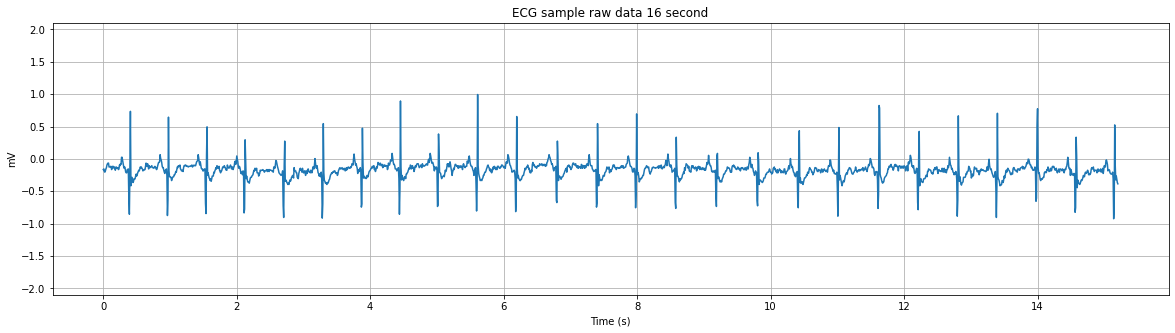

In [11]:
start = df_ecg.index[0].time()
end = (df_ecg.index[0] + datetime.timedelta(seconds=16)).time()
print(start, end)

plot_signal(df_ecg.between_time(start,end), fs, "ECG sample raw data 16 second")

08:04:16 08:04:32


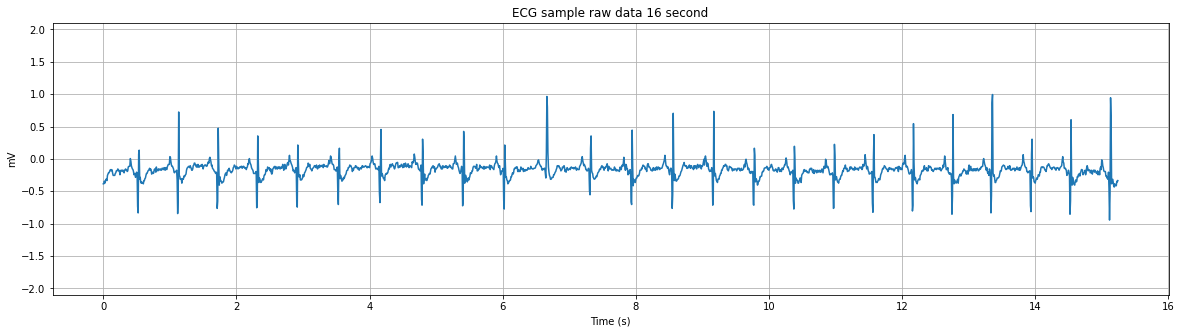

In [12]:
start = (df_ecg.index[0] + datetime.timedelta(seconds=16)).time()
end = (df_ecg.index[0] + datetime.timedelta(seconds=32)).time()
print(start, end)

plot_signal(df_ecg.between_time(start,end), fs, "ECG sample raw data 16 second")

- split each N & AFIB dataframe to 16s sequence and apply Baseline Removal 

In [13]:
from scipy import sparse
from scipy.sparse.linalg import spsolve
from datetime import timedelta

In [14]:
def plot_16s_sample(data, label="Plot 16 s sample", y_label = 'mV'):
    times = np.arange(data.shape[0], dtype='float') / fs
    
    plt.figure(figsize=(20, 5))
    plt.plot(times, data)
    plt.title(label)
    plt.xlabel('Time (s)')
    plt.ylabel(y_label)
    plt.grid(True)
    plt.show()

In [15]:
def baseline_als(y, lam=10000, p=0.05, n_iter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(n_iter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [16]:
def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

In [17]:
time_interval = []
if len(df_ecg) > 0:
    intr = [time_result for time_result in perdelta(df_ecg.index[0], df_ecg.index[-1], timedelta(seconds=16))]
    time_interval.append(intr)

In [18]:
ECG_ALS = []
ECG_ALS_label = []

for tm_int in time_interval :
    for time_intv in list(zip(tm_int, tm_int[1:])):
        X = df_ecg.between_time(time_intv[0].time(), time_intv[1].time())
        X_val = X.values[:,0]
        if len(X_val) > 0 :
            ALS = X_val - baseline_als(X_val)
            ECG_ALS.append(np.array(ALS))
            ECG_ALS_label.append('N')

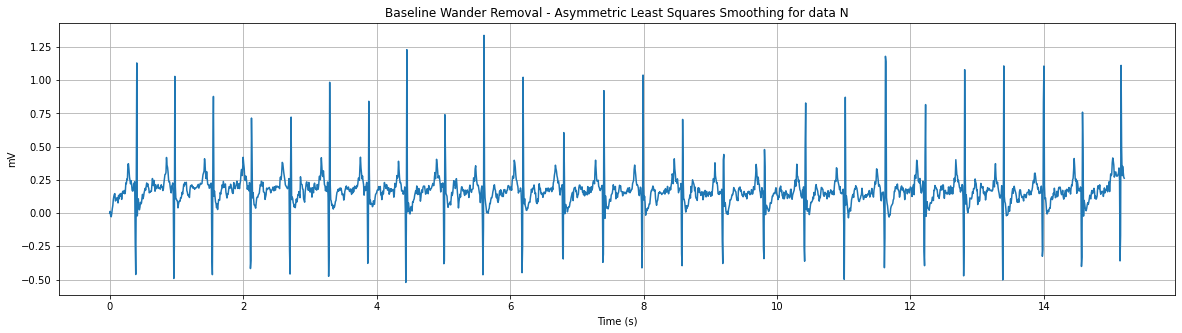

In [19]:
idx = 0
plot_16s_sample(ECG_ALS[idx], label="Baseline Wander Removal - Asymmetric Least Squares Smoothing for data %s" % ECG_ALS_label[idx])

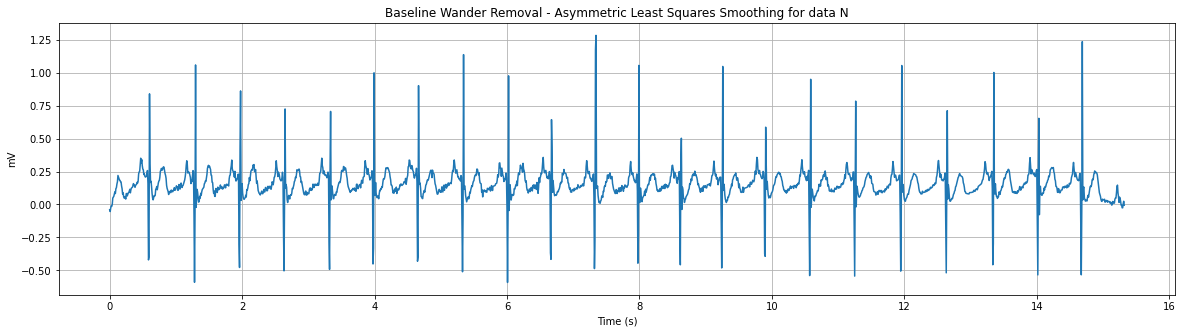

In [20]:
idx = -3
plot_16s_sample(ECG_ALS[idx], label="Baseline Wander Removal - Asymmetric Least Squares Smoothing for data %s" % ECG_ALS_label[idx])

- Signal normalization from -1 to 1

In [21]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler

In [22]:
#scaler = MinMaxScaler(feature_range=(-1, 1)) # scale to -1 to 1
scaler = MaxAbsScaler()
ECG_ALS_Norm = []

for als in ECG_ALS :
    als = np.expand_dims(als, 1)
    scaler = scaler.fit(als)
    
    als_norm = scaler.transform(als) 
    ECG_ALS_Norm.append(als_norm)

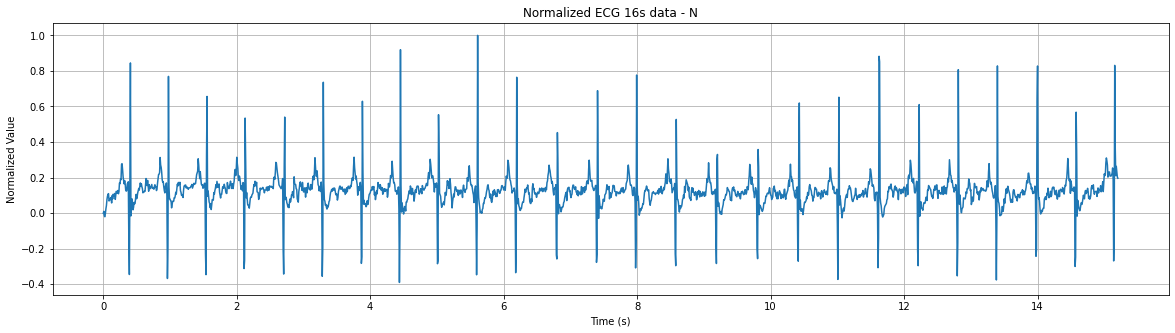

In [23]:
idx = 0
plot_16s_sample(ECG_ALS_Norm[idx], "Normalized ECG 16s data - %s" % ECG_ALS_label[idx], y_label = 'Normalized Value')

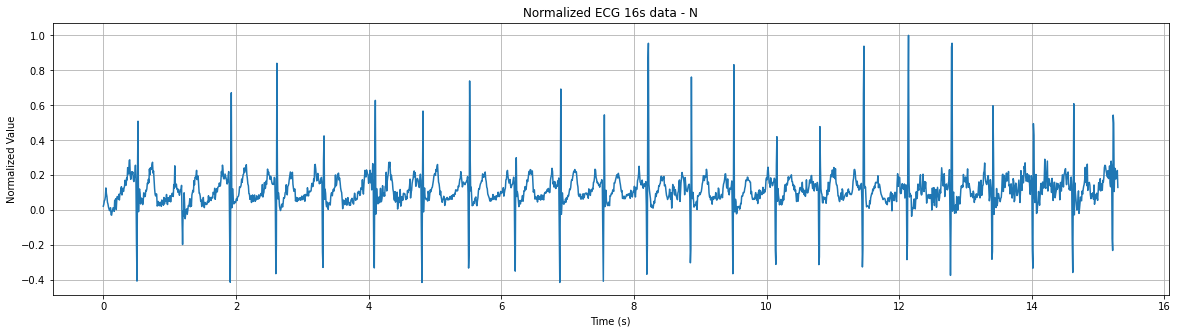

In [24]:
idx = -1
plot_16s_sample(ECG_ALS_Norm[idx], "Normalized ECG 16s data - %s" % ECG_ALS_label[idx], y_label = 'Normalized Value')

- Upsampling (128Hz to 250Hz)

In [25]:
def upsampling_twice(data):
    # upsampling interpolation
    result = np.zeros(2*len(data)-1)
    result[0::2] = data
    result[1::2] = (data[1:] + data[:-1]) / 2
    return result

In [26]:
new_fs = 250 # Hz 
ECG_ALS_Norm_Up = []
for data in ECG_ALS_Norm :
    data = np.array(data[:,0])
    data = upsampling_twice(data) 
    ECG_ALS_Norm_Up.append(data)

- QRS Detection

In [27]:
from ecgdetectors import Detectors

detectors = Detectors(new_fs)

In [28]:
def plot_r_peaks(r_peaks, data, fs, label = "Detected R peaks"):
    times = np.arange(data.shape[0], dtype='float') / fs

    ymin = np.min(data)
    ymax = np.max(data)
    alpha = 0.2 * (ymax - ymin)
    ymax += alpha
    ymin -= alpha

    plt.figure(figsize=(20, 5))
    plt.plot(times, data)
    
    plt.vlines([r / fs for r in r_peaks], ymin, ymax,
               color="r",
               linewidth=2)

    plt.title(label)
    plt.xlabel('Time (s)')
    plt.ylabel('mV')
    plt.grid(True)
    plt.show()

- Test R peak detector - Christov

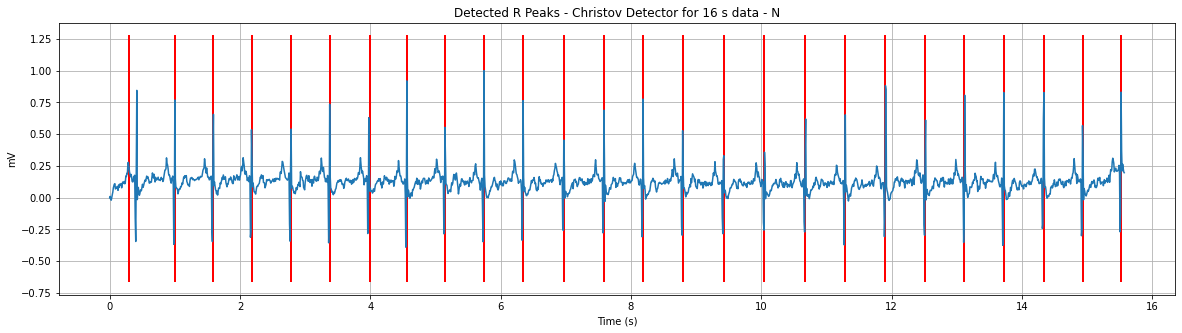

In [29]:
idx = 0

data = np.array(ECG_ALS_Norm_Up[idx])

r_peaks = detectors.christov_detector(data)

plot_r_peaks(r_peaks, data, new_fs, label="Detected R Peaks - Christov Detector for 16 s data - %s" % ECG_ALS_label[idx])

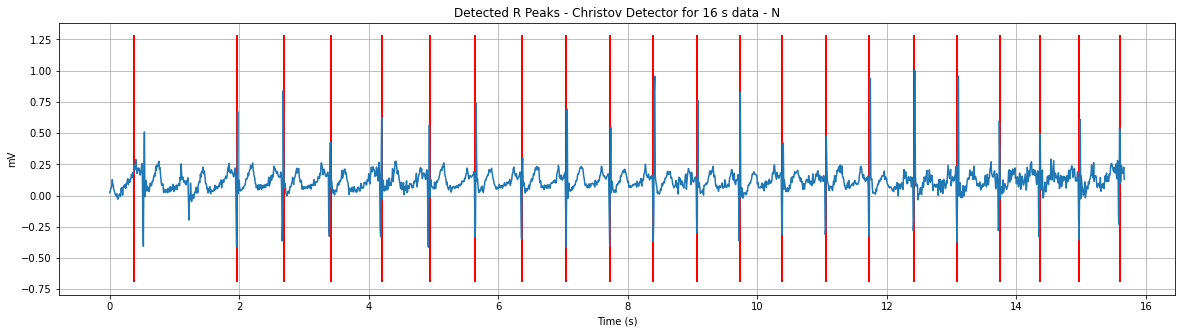

In [30]:
idx = -1

data = np.array(ECG_ALS_Norm_Up[idx])

r_peaks = detectors.christov_detector(data)

plot_r_peaks(r_peaks, data, new_fs, label="Detected R Peaks - Christov Detector for 16 s data - %s" % ECG_ALS_label[idx])

- Split each 16s to 1.2 x R-R sequence
- Padding the sequence with zero for length 300 point

In [31]:
ECG_split = []
ECG_split_label = []
for i in range(len(ECG_ALS_Norm_Up)) :
    data = np.array(ECG_ALS_Norm_Up[i])
    if len(data) > 0:
        r_peaks = []
        try :
            r_peaks = detectors.christov_detector(data)
        except:
            print("cannot find R peaks in ALS Norm, idx %d" % i)
        RRs = np.diff(r_peaks)
        RRs_med = np.median(RRs)
        if not np.isnan(RRs_med) and RRs_med > 0:
            for rp in r_peaks :
                split = data[rp : rp + int(RRs_med * 1.2)] 
                pad = np.zeros(300)
                n = len(split) if len(split) <= 300 else 300
                pad[0:n] = split[0:n]
                ECG_split.append(pad)
                ECG_split_label.append(ECG_ALS_label[i])

In [32]:
def plot_1_sample(data, label, fs):
    times = np.arange(data.shape[0]) / fs * 1000 

    label = 'Normal' if label == 'N' else 'Atrial Fibrillation'
    plt.plot(times, data)
    plt.title("Plot 1 Sample (%dHz) : %s Beat" % (fs, label))
    plt.xlabel("Time (ms)")
    plt.ylabel("mV")
    plt.grid(True)
    plt.show()

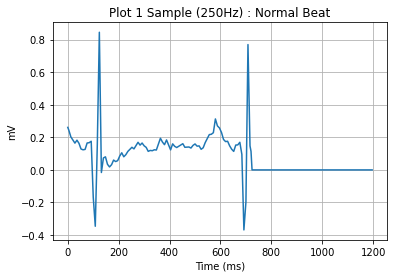

In [33]:
idx = 0
plot_1_sample(ECG_split[idx], ECG_split_label[idx], new_fs)

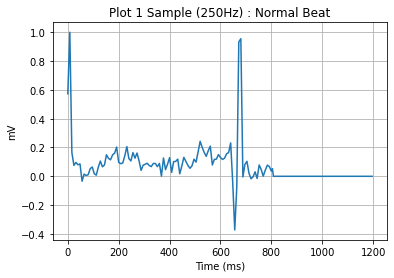

In [34]:
idx = -6
plot_1_sample(ECG_split[idx], ECG_split_label[idx], new_fs)

In [35]:
data = []
for i in range(len(ECG_split)):
    x = list(ECG_split[i])
    x.append(ECG_split_label[i])
    data.append(x)

In [36]:
ECG = pd.DataFrame(data)

In [37]:
ECG.tail()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
2064,-0.224669,-0.077117,0.428114,0.933345,0.944157,0.954969,0.475060,-0.004849,0.038945,0.082738,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
2065,0.464612,0.331576,0.154135,-0.023306,0.024140,0.071586,0.070960,0.070333,0.054843,0.039352,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
2066,0.462118,0.428881,0.255320,0.081759,0.062988,0.044217,0.065893,0.087569,0.146013,0.204457,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
2067,-0.112536,0.130654,0.369991,0.609328,0.291505,-0.026318,0.065171,0.156660,0.129975,0.103289,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N
2068,0.499023,0.303115,0.107208,0.173191,0.239174,0.238749,0.238325,0.208383,0.178442,0.181695,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N


In [38]:
ECG.to_csv("dataset/NSRDB_%s_sequence_300_pt.csv" % record, index=False, header=False)